<a target="_blank" href="https://colab.research.google.com/github/mlolab/optML-course/blob/main/labs/ex10/ex10.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Federated Learning Tutorial: Effect of Data Heterogenity

Federated Learning is a distributed approach where multiple devices train a global model without sharing raw data. In this notebook, we'll study the impact of data heterogeneity on Logistic Regression and Deep Convolutional Neural Network models in Federated Learning. The process involves:

1. **Initialization:** Start with a global model.
2. **Client Selection:** Choose clients to participate in training.
3. **Local Model Training:** Clients train the global model using their local data.
4. **Model Update Exchange:** Clients send their updated model weights to a central server.
5. **Model Aggregation:** The server averages the received model weights.
6. **Global Model Update:** The aggregated model weights are applied to the global model.
7.**Repeat:** Steps 2-6 are repeated for multiple rounds.

We'll analyze how variations in data heterogeneity impact the convergence and performance of the models, considering factors like data distributions and class imbalances.



### Imports

In [ ]:
# Standard Python imports
import os
import random
import time

## Python Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

## PyTorch

import torch
import torch.nn as nn
import torch.optim as optim
import copy
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.utils.data import Subset, random_split

## Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST


### Jupyter
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

### Helper Functions

In [ ]:
def mnist_iid(dataset, num_users):

    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

def distribution_noniid(dataset, num_clients, num_classes=10, alpha=0.5):
    idx = [torch.where(dataset.targets == i) for i in range(num_classes)]
    data = [dataset.data[idx[i][0]] for i in range(num_classes)]

    s = np.random.dirichlet(np.ones(num_classes) * alpha, num_clients)

    data_dist = np.zeros((num_clients, num_classes))
    for j in range(num_clients):
        data_dist[j] = ((s[j] * len(data[0])).astype('int') / (s[j] * len(data[0])).astype('int').sum() * len(data[0])).astype('int')
        data_num = data_dist[j].sum()
        data_dist[j][np.random.randint(low=0, high=num_classes)] += (len(data[0]) - data_num)
        data_dist = data_dist.astype('int')

    dict_users = {}
    for j in range(num_clients):
        dict_users[j] = []
        for i in range(num_classes):
            d_index = np.random.choice(idx[i][0], size=data_dist[j][i], replace=False)
            dict_users[j].extend(d_index.tolist())

    return dict_users

In [ ]:
import torch
import numpy as np
from torch.utils.data import Subset

def subsample_mnist(train_dataset, subsampling_ratio=0.25):
    class_counts = torch.bincount(train_dataset.targets)
    num_samples_per_class = int(subsampling_ratio * torch.min(class_counts))
    indices = []

    for class_label in range(10):
        class_indices = torch.where(train_dataset.targets == class_label)[0]
        selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
        indices.extend(selected_indices.tolist())

    subset = Subset(train_dataset, indices)
    subset.targets = train_dataset.targets[indices]
    subset.data = train_dataset.data[indices]

    return subset


In [ ]:
def get_dataset(num_clients, num_classes = 10, alpha = 0.5):
    data_dir = '../data/mnist/'


    apply_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

    train_dataset = MNIST(data_dir, train=True, download=True,
                                    transform=apply_transform)

    test_dataset = MNIST(data_dir, train=False, download=True,
                                  transform=apply_transform)
    train_dataset, test_dataset = subsample_mnist(train_dataset, 0.25), subsample_mnist(test_dataset, 0.25)

    train_user_groups = distribution_noniid(train_dataset, num_clients, num_classes = 10, alpha = alpha)

    return train_dataset, test_dataset, train_user_groups


In [ ]:
class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

#### Plotting Function

In [ ]:
def plot_image_grid(images, ncols=None, cmap="gray", column_titles=None):
    if not ncols:
        factors = [i for i in range(1, len(images) + 1) if len(images) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1
    nrows = int(len(images) / ncols) + int(len(images) % ncols)
    imgs = [images[i] if len(images) > i else None for i in range(nrows * ncols)]
    f, axes = plt.subplots(nrows, ncols, figsize=(14, 8), dpi=80)
    axes = axes.flatten()[: len(imgs)]
    for img, ax in zip(imgs, axes.flatten()):
        if np.any(img):
            ax.imshow(img)
            if column_titles:
                for i, title in enumerate(column_titles):
                    axes[i].set_title(title)

### Model definitions

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [ ]:
class LogReg(nn.Module):
  def __init__(self):
    super(LogReg, self).__init__()
    self.in_layer = nn.Linear(1 * 32 * 32, 10)

  def forward(self, x):
    x = self.in_layer(x.view(-1, 1024))
    return x

In [ ]:
class FedAvg(nn.Module):
  def __init__(self, train_params):
    super(FedAvg, self).__init__()

    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.num_clients = train_params['num_clients']
    self.alpha = train_params['alpha']
    self.train_ds, self.test_ds, self.train_splits = get_dataset(num_clients=self.num_clients, alpha=self.alpha)

    self.lr = 0.01
    self.local_epochs = train_params['local_epochs']
    self.criterion = nn.CrossEntropyLoss()
    self.task_type = train_params['task_type']

    if self.task_type == 'logistic-regression':
      self.global_model = LogReg()
    else:
      self.global_model = LeNet5(10)
    self.global_model.to(self.device)
    self.local_model_list = [copy.deepcopy(self.global_model) for _ in range(self.num_clients)]
    self.optimizer_list = [optim.SGD(model.parameters(), lr = self.lr) for model in self.local_model_list]
    self.test_dl = self.create_dataloaders(test_dataset = self.test_ds)


  def create_dataloaders(self, train_dataset = None, idxs_train = None, test_dataset = None):
        if train_dataset is not None and idxs_train is not None:

          trainloader = DataLoader(DatasetSplit(train_dataset, idxs_train),
                                  batch_size=32, shuffle=True)
          return trainloader
        if test_dataset is not None:
          testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
          return testloader

  def train_one_round(self):
    for client_idx, (model, split, optim) in enumerate(zip(self.local_model_list, self.train_splits, self.optimizer_list)):
      model.train()
      train_dl = self.create_dataloaders(train_dataset = self.train_ds, idxs_train = self.train_splits[client_idx])
      print(f'Training Client {client_idx}')
      for epochs in range(self.local_epochs):
        for (data, label) in tqdm.tqdm(train_dl):
          optim.zero_grad()
          data, label = data.to(self.device), label.to(self.device)
          output = model(data)
          loss = self.criterion(output, label)
          loss.backward()
          optim.step()

    global_dict = self.global_model.state_dict()
    total_size = len(self.train_ds)
    ds_size_list = [len(self.train_splits[k]) for k in self.train_splits]
    for k in global_dict.keys():
        weights = [self.local_model_list[i].state_dict()[k] * (ds_size_list[i] / total_size) for i in range(len(self.local_model_list))]
        global_dict[k] = sum(weights)
    self.global_model.load_state_dict(global_dict)

    return self.global_model

  def test_global_model(self):
    test_loss = 0
    correct = 0
    self.global_model.eval()

    with torch.no_grad():
      for data, label in tqdm.tqdm(self.test_dl):
        data, label = data.to(self.device), label.to(self.device)
        output = self.global_model(data)
        test_loss += self.criterion(output, label)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()
    test_loss /= len(self.test_dl.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%'.format( test_loss, correct, len(self.test_dl.dataset), 100. * correct / len(self.test_dl.dataset)))

    return 100. * correct / len(self.test_dl.dataset)


## Part One: Visualizing Heterogenous (Non-IID) data
A common method to simulate Non-IID data distributions from exisiting IID datasets is via the use of the Dirichlet Distribution.

The Dirichlet distribution is a way to generate data for different categories. The concentration parameters, denoted as α, determine the characteristics of the generated data. When the concentration parameters are equal, the generated data is independent and evenly distributed (IID).

To simulate non-IID data, we can vary the concentration parameters. By setting different values for α, we introduce biases and correlations among the categories. Higher values for α make a category more likely, while lower values make it less likely.

In essence, tweaking α allows us to control the behavior of the generated data, making it non-IID by introducing variations, biases, and correlations among the categories.

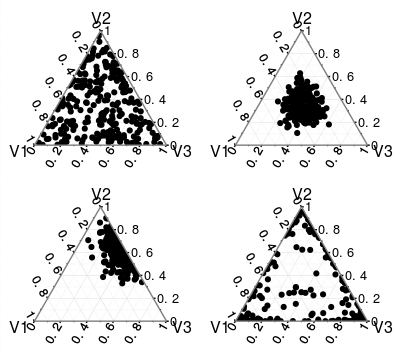

[Source](https://stats.stackexchange.com/questions/244917/what-exactly-is-the-alpha-in-the-dirichlet-distribution)

In this exercise, you can visualize Non-IID data distribution variations by adjusting 'alpha' (Dirichlet distribution parameter), the number of clients, and comparing with the IID option.

Observations on varying alpha and its impact on data distribution at each client:

- For smaller alpha values, the data distribution tends to be more skewed towards specific classes, resulting in class imbalances within clients.
- Larger alpha values lead to a more uniform distribution across classes for each client, reducing class imbalances.

Plot description:

- Each bar represents a client.
- Colors represent different class labels.
- The width of each bar corresponds to the number of samples for a specific class in a given client.

In [ ]:
@widgets.interact(alpha=widgets.RadioButtons(options=[0.01, 0.5, 1.5, 25]), num_clients=widgets.RadioButtons(options=[2, 3, 4, 9, 10]))
def plot_distribution(alpha, num_clients):

    train_dataset, test_dataset, train_user_groups = get_dataset(num_clients=num_clients, alpha=alpha)
    data = [train_dataset.targets[list(train_user_groups[i])].numpy() for i in range(num_clients)]


    colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'orange', 4: 'purple', 5: 'yellow', 6: 'pink', 7: 'cyan', 8: 'magenta', 9: 'black'}
    num_bins = len(colors)

    fig, axes = plt.subplots(nrows=len(data), ncols=1, sharex=True, sharey=True)
    fig.subplots_adjust(hspace=2.0)

    for i, d in enumerate(data):
        counts = np.bincount(d, minlength=num_bins)
        width = 0.2
        left = 0
        for j, k in enumerate(range(num_bins)):
            count = counts[k]
            axes[i].barh(0, count, height=width, left=left, color=colors[k])
            left += count
        axes[i].set_title('Client {}'.format(i+1), fontsize=8)
        axes[i].set_yticks([])
        axes[i].set_yticklabels([])
        axes[i].set_xlim([0, np.sum(counts)])
    fig.text(0.5, 0.04, 'Count', ha='center')
    fig.text(0.04, 0.5, 'Clients', va='center', rotation='vertical')

    plt.show()

## Part Two: Explore if (and how) data heterogenity impacts Federated Learning Training


In this exercise, we will explore the impact of data heterogeneity on training models in a federated learning (FL) setting. Data heterogeneity refers to the non-IID or heterogeneous nature of the data distributed across clients in FL.

To investigate this, we will train either a Logistic Regression classifier or a Convolutional Neural Network (CNN) model on a subset of the MNIST dataset. The training will be performed with varying combinations of alpha (representing data distribution) and the number of clients.

After running the code, which may take some time, you will obtain accuracy plots on a logarithmic scale. Analyze these plots to understand the effect of data heterogeneity.

In the markdown cell below the code, write your observations regarding the impact of data heterogeneity. You can also experiment by adjusting different parameters in the code cells to explore further.

In [ ]:
## Grid for exploration
results_dict = {}

import itertools

alphas = [0.01, 0.5, 1.5, 25]
client_nos = [5]
local_epochs = [5]
tasks = ['CNN', 'logistic_regression']
rounds = 3

param_combinations = list(itertools.product(alphas, client_nos, local_epochs, tasks))

train_params = [{'alpha': alpha, 'num_clients': client_no, 'local_epochs': local_epoch, 'task_type': task, 'epochs': rounds} for alpha, client_no, local_epoch, task in param_combinations]

In [ ]:

for train_config in train_params:
  print('+++' * 30)
  print(f"Working on Task_{train_config['task_type']}, Alpha_{train_config['alpha']}, Num Clients_{train_config['num_clients']}, Local Epochs {train_config['local_epochs']}")
  print('+++' * 30)
  fed_avg_model = FedAvg(train_config)
  test_acc_list = []
  for epoch in range(train_config['epochs']):
    fed_avg_model.train_one_round()
    test_acc_list.append(fed_avg_model.test_global_model())
  results_dict[f"Task_{train_config['task_type']}, Alpha_{train_config['alpha']}, Num Clients_{train_config['num_clients']}, Local Epochs {train_config['local_epochs']}"] = test_acc_list
  print('---------------')
  print('----> Complete!')
  print('---------------')

## Visualization and Exploration

What are your observations on the impact of alpha on the final training accuracy of the model?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

logistic_accuracies = []
logistic_log_alphas = []
cnn_accuracies = []
cnn_log_alphas = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for i, key in enumerate(results_dict):
    alpha = float(key.split(',')[1].split('_')[-1])
    log_alpha = np.log10(alpha)

    if 'logistic_regression' in key:
        accuracy = results_dict[key][-1]
        logistic_accuracies.append(accuracy)
        logistic_log_alphas.append(log_alpha)

    elif 'CNN' in key:
        accuracy = results_dict[key][-1]
        cnn_accuracies.append(accuracy)
        cnn_log_alphas.append(log_alpha)


ax1.plot(logistic_log_alphas, logistic_accuracies)
ax1.set_title('Final Accuracy vs. Log Alpha (Logistic Regression)')
ax1.set_xlabel('Log(Dirichlet Alpha)')
ax1.set_ylabel('Final Accuracy')
ax1.set_xticks(logistic_log_alphas)

ax2.plot(cnn_log_alphas, cnn_accuracies)
ax2.set_title('Final Accuracy vs. Log Alpha (CNN)')
ax2.set_xlabel('Log(Dirichlet Alpha)')
ax2.set_ylabel('Final Accuracy')
ax2.set_xticks(cnn_log_alphas)

plt.tight_layout()
plt.show()
